In [1]:
import pandas as pd
import cobra
import numpy as np
import os
import matplotlib.pyplot as plt
#Also needed to install ipykernel to run this on jupyter
#Needed to install openpyxl to open the excel spreadsheet with pandas


base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')

# Saccharomyces_cerevisiae flux data: OG-flux
# Obtained gene-flux through gene-OG

In [2]:
OG2gene_file = base_dir + os.sep + os.path.normpath('costs/Sce_Flux_C13/Saccharomyces_cerevisiae.tsv')
OG2gene = pd.read_csv(OG2gene_file,sep='\t')
OG2gene = OG2gene[['ortholog_id','gene_id']]
OG2gene

OG2gene_dict = {}
for index,row in OG2gene.iterrows():
    OG2gene_dict[row['ortholog_id']] = row['gene_id']
OG2gene_dict


sce_flux_file = base_dir + os.sep + os.path.normpath('costs/Sce_Flux_C13/OG_flux_updated.xlsx')
sce_flux = pd.read_excel(sce_flux_file,sheet_name='Fluxes')
sce_flux = sce_flux[['Average Fluxes on different 1Cmmol substrates (mmol/gDW/h)','Saccharomyces_cerevisiae']]
sce_flux['gene'] = sce_flux['Average Fluxes on different 1Cmmol substrates (mmol/gDW/h)'].apply(lambda x:OG2gene_dict[x] if x in OG2gene_dict else 'nogene')
sce_flux = sce_flux[sce_flux['gene']!='nogene']
sce_flux.head(3)

,Average Fluxes on different 1Cmmol substrates (mmol/gDW/h),Saccharomyces_cerevisiae,gene
0,OG1000,0.000000,YLL048C
3,OG1001,0.039382,YGR191W
5,OG1003,0.000452,YOR328W


In [3]:
print(len(sce_flux))
print(len(set(sce_flux['gene'].to_list())))

gene2flux = {}
for index,row in sce_flux.iterrows():
    gene2flux[row['gene']] = row['Saccharomyces_cerevisiae']
    
print(gene2flux)

1094
1094
{'YLL048C': 0.0, 'YGR191W': 0.039381858050409, 'YOR328W': 0.000452291192958654, 'YKR086W': 0.000868155570714056, 'YKL220C': 3.50263882182844e-05, 'YER171W': 0.0, 'YGL039W': 0.122291261009652, 'YER166W': 0.027584278020754, 'YPR194C': 0.0, 'YNL192W': 0.0, 'YDL245C': 0.251616816320283, 'YLR342W': 0.0120099389099406, 'YOR306C': 6.65828495129972e-05, 'YOL086C': 0.0427280326447409, 'YGR260W': 8.36703372030461e-05, 'YDL174C': 0.0, 'YCR105W': 0.00055390218300765, 'YOR374W': 0.00256238164980091, 'YHR104W': 0.0915262701410531, 'YDL138W': 0.0, 'YKR001C': 0.00326587351695757, 'YKL173W': 0.0, 'YGR224W': 0.000103777440511008, 'YLR058C': 0.220070768926094, 'YJL130C': 0.0378221455777202, 'YOR304W': 0.0, 'YLR304C': 0.0228716035164541, 'YBR298C': 0.255996576540766, 'YHR047C': 0.0, 'YNR067C': 0.0113485986299198, 'YOL011W': 0.0013719955811916, 'YOR120W': 0.0669643803616717, 'YMR054W': 0.0, 'YDL210W': 0.201162561555588, 'YEL032W': 0.0, 'YIL126W': 0.0, 'YPL096C-A': 0.0, 'YBR084W': 0.25004667502412

# C13 data: reactionID-C13
# Obtained through Yeast8: reactionID-gpr-C13
# Split gpr to get: reactionID-gene-C13

In [4]:
C13_data_file = base_dir + os.sep + os.path.normpath('costs/Sce_Flux_C13/FluxMeasurements.xlsx')
C13_data = pd.read_excel(C13_data_file,sheet_name='Relative')

yeast8 = cobra.io.load_yaml_model(base_dir + os.sep + os.path.normpath('costs/Sce_Flux_C13/yeast-GEM870.yml'))

for index,row in C13_data.iterrows():
    reaction_name = row['Data normalized to specific glucose uptake rate']
    gene = str(yeast8.reactions.get_by_id(reaction_name.replace('_fwd','').replace('_rvs','')).gene_reaction_rule)
    gene_list = gene.replace(')','').replace('(','').replace(' or ',' ').replace(' and ',' ').split(' ')
    # print(gene)
    # print(gene_list)
    C13_data.at[index,'gene_list'] = gene_list

C13_data_exploded = C13_data.explode('gene_list')
C13_data_exploded.head(3)

,Data normalized to specific glucose uptake rate,Protein,Gombert_Batch(PMID11157958),Gombert_ClimD01(PMID11157958),Raghevendran_Batch(PMID15282800),DaranLapujade_ClimD01(PMID14630934),Kajihata_ClimD01(PMID25634548),Blank_Batch(PMID15960801),Jouhten_ClimD01(PMID18613954),gene_list
0,r_0467_fwd,﻿Pgi1,81,33.6,74.910714,42.905405,12.9,85,48.5,YBR196C
1,r_0886,﻿Pfk1/2,91,60.3,88.303571,63.513514,52,91,63.5,YGR240C
1,r_0886,﻿Pfk1/2,91,60.3,88.303571,63.513514,52,91,63.5,YMR205C


# Step one to obtain: gene-flux
# Step two to obtain: gene-C13
# Mapping, delete genes that cannot map to flux

In [5]:
C13_data_exploded['flux'] = C13_data_exploded['gene_list'].apply(lambda x:gene2flux[x] if x in gene2flux else 'noflux')
C13_data_exploded= C13_data_exploded[C13_data_exploded['flux']!='noflux']
C13_data_exploded.loc[:, 'flux'] = C13_data_exploded['flux'].astype(float)
print(C13_data_exploded.shape)
C13_data_exploded.iloc[:, 2:9] = C13_data_exploded.iloc[:, 2:9].replace(0, 'na')
C13_data_exploded = C13_data_exploded[C13_data_exploded.apply(lambda x: x == 'na').sum(axis=1) < 2]
print(C13_data_exploded.shape)
C13_data_exploded.head(3)

(63, 11)
(33, 11)


,Data normalized to specific glucose uptake rate,Protein,Gombert_Batch(PMID11157958),Gombert_ClimD01(PMID11157958),Raghevendran_Batch(PMID15282800),DaranLapujade_ClimD01(PMID14630934),Kajihata_ClimD01(PMID25634548),Blank_Batch(PMID15960801),Jouhten_ClimD01(PMID18613954),gene_list,flux
0,r_0467_fwd,﻿Pgi1,81,33.6,74.910714,42.905405,12.9,85,48.5,YBR196C,0.085739
1,r_0886,﻿Pfk1/2,91,60.3,88.303571,63.513514,52,91,63.5,YMR205C,0.110857
2,r_0466,﻿Zwf1,16.2,44.2,21.517857,34.459459,72.5,11,27,YNL241C,0.093399


# Correlation analysis of experimental data and flux
# For each set of experimental data, remove rows with na; this step does not affect each other.

average_correlation: 0.7999654486312867


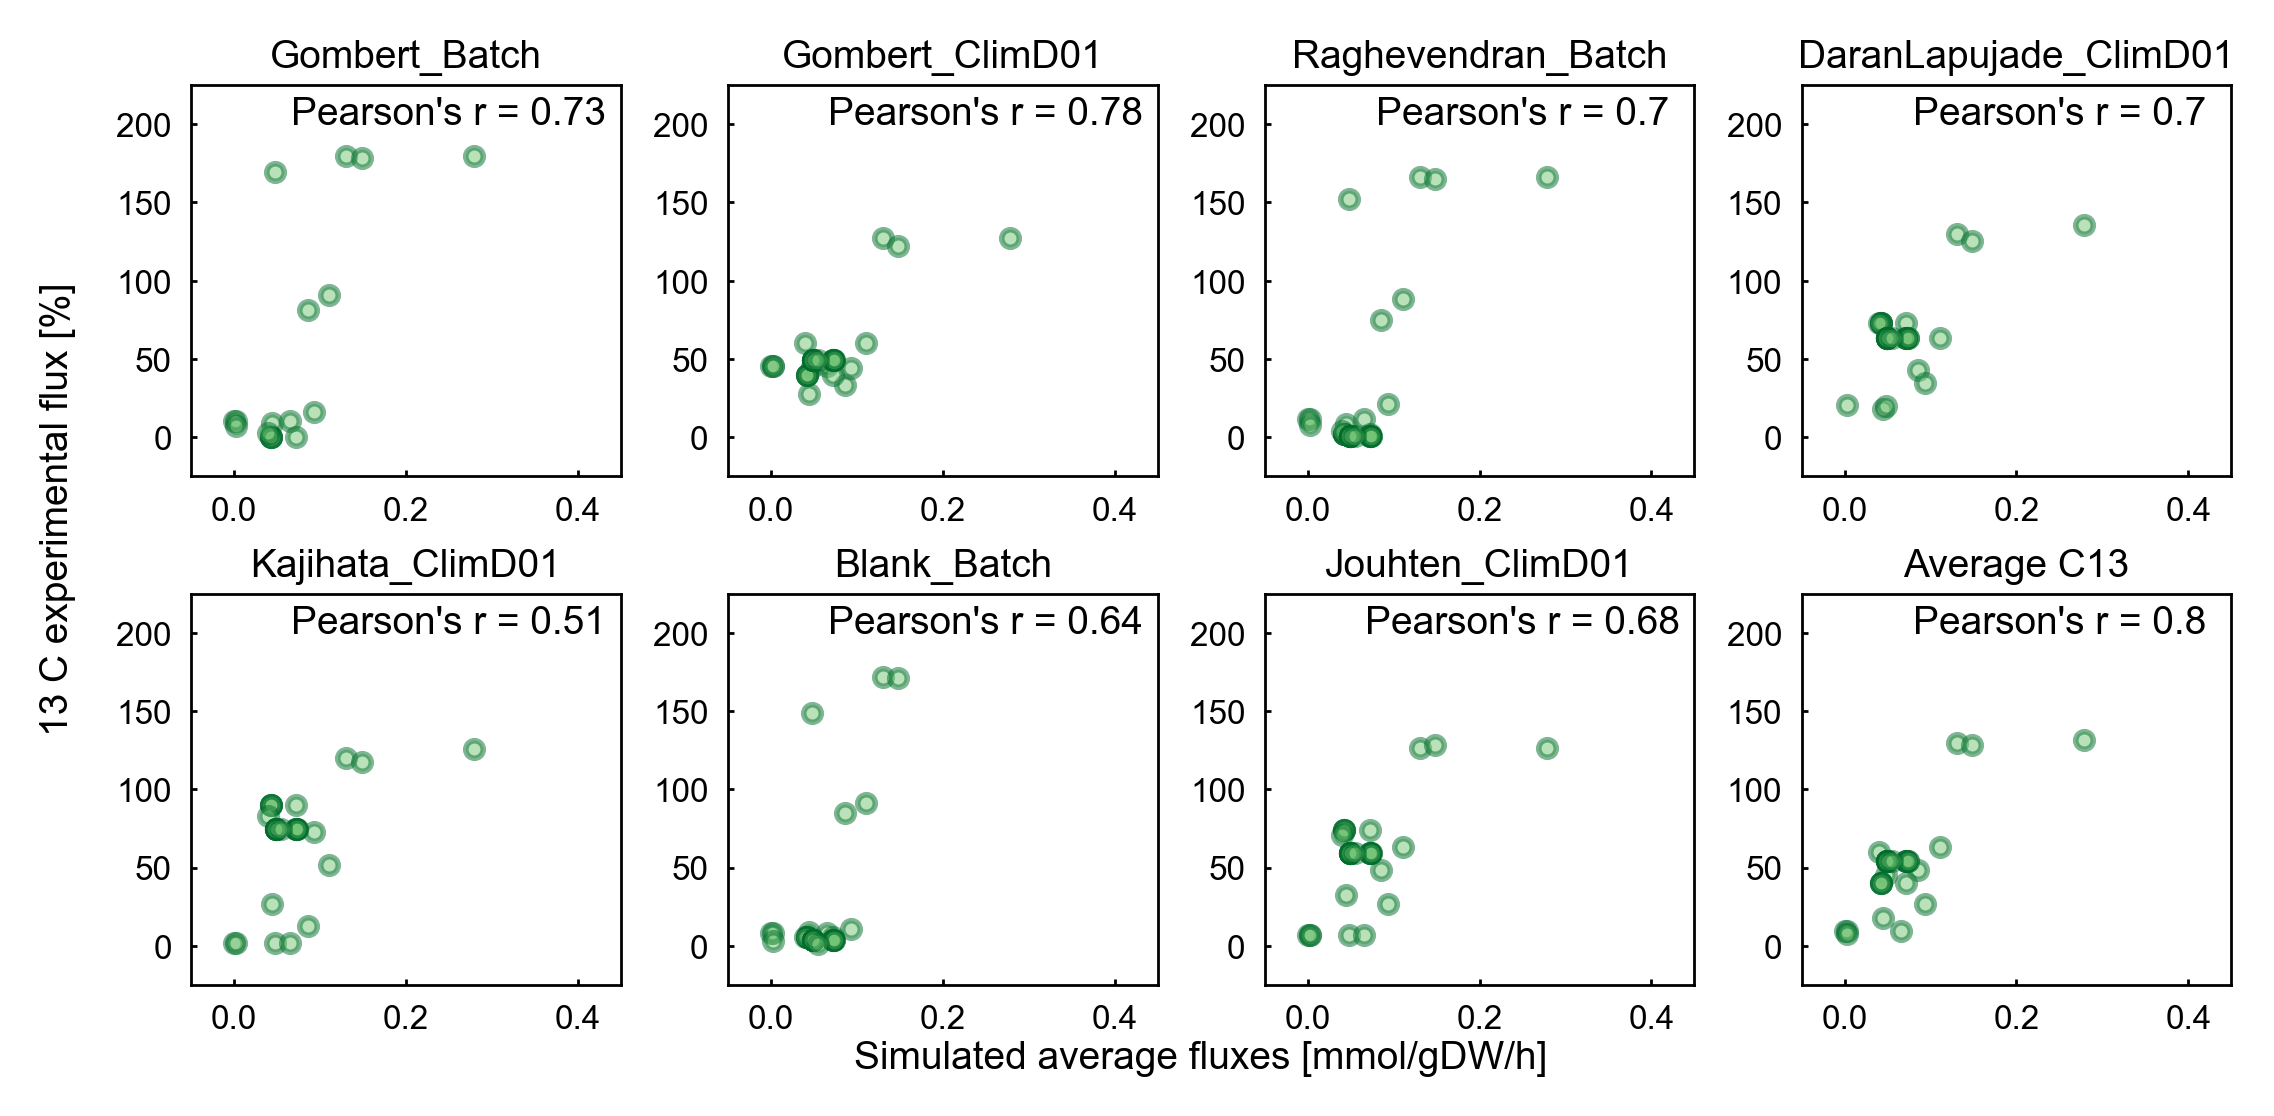

In [7]:

plt.rcParams['svg.fonttype'] = 'none'

fig, axs = plt.subplots(2, 4, figsize=(6, 3), dpi=400)
plt.rcParams.update({'font.size': 7})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

axs = axs.flatten()

for i, column in enumerate(C13_data_exploded.columns[2:9]):
    tmp = C13_data_exploded[C13_data_exploded[column] != 'na'].copy()
    tmp.loc[:, column] = tmp[column].astype(float)
    tmp.loc[:, 'flux'] = tmp['flux'].astype(float)

    correlation = tmp['flux'].corr(tmp[column])
    axs[i].scatter(tmp['flux'], tmp[column], s=10, c='#74c476', edgecolor='#006d2c',alpha=0.5)
    axs[i].tick_params(axis='x', direction='in', width=0.5, which='both', length=1,labelsize=6)
    axs[i].tick_params(axis='y', direction='in', width=0.5, which='both', length=1,labelsize=6)
    # axs[i].set_xlabel('Simulated average fluxes [mmol/gDW/h]', fontsize=7, labelpad=1)
    # axs[i].set_ylabel('13 C experimental flux [%]', fontsize=7, labelpad=1)
    axs[i].set_ylim(-25, 225)
    axs[i].set_xlim(-0.05, 0.45)
    axs[i].set_title(column.split('(')[0], fontsize=7, y=0.96)
    axs[i].text(0.25, 200, "Pearson's r = " + str(round(correlation, 2)), fontsize=7, ha='center')

for ax in axs:
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)

C13_data_exploded.iloc[:, 2:9] = C13_data_exploded.iloc[:, 2:9].replace('na', np.nan)
# average_series = C13_data_exploded.iloc[:, 2:9].astype(float).mean(axis=1, skipna=True)
average_series = C13_data_exploded.iloc[:, 2:9].astype(float).median(axis=1, skipna=True)
average_correlation = C13_data_exploded['flux'].corr(average_series)
print(f"average_correlation: {average_correlation}")
axs[-1].scatter(C13_data_exploded['flux'], average_series, s=10, c='#74c476', edgecolor='#006d2c',alpha=0.5)
axs[-1].tick_params(axis='x', direction='in', width=0.5, which='both', length=1,labelsize=6)
axs[-1].tick_params(axis='y', direction='in', width=0.5, which='both', length=1,labelsize=6)
# axs[-1].set_xlabel('Simulated average fluxes [mmol/gDW/h]', fontsize=7, labelpad=1)
# axs[-1].set_ylabel('13 C experimental flux [%]', fontsize=7, labelpad=1)
axs[-1].set_ylim(-25, 225)
axs[-1].set_xlim(-0.05, 0.45)
axs[-1].set_title('Average C13'.split('(')[0], fontsize=7, y=0.96)
axs[-1].text(0.25, 200, "Pearson's r = " + str(round(average_correlation, 2)), fontsize=7, ha='center')

plt.subplots_adjust(left=0.1, right=0.95, top=0.85, bottom=0.1, hspace=0.3, wspace=0.25)
plt.text(-2.08, 140, "13 C experimental flux [%]", fontsize=7, ha='center',rotation=90)
plt.text(-0.75, -78, "Simulated average fluxes [mmol/gDW/h]", fontsize=7, ha='center')
plt.savefig(base_dir + os.sep + os.path.normpath('costs/Sce_Flux_C13/combined_plot.svg'), dpi=300, bbox_inches='tight')
plt.show()